In [ ]:
# prompt: code for google drive mounting

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


New Codde 11/18/24


Step 1: Backbone Network

In [ ]:
import torch
import torch.nn as nn

class Hourglass(nn.Module):
    def __init__(self, depth, num_features):
        super(Hourglass, self).__init__()
        self.depth = depth
        self.num_features = num_features
        self._generate_network(self.depth)

    def _generate_network(self, level):
        self.add_module(f"down_{level}", nn.Sequential(
            nn.Conv2d(self.num_features, self.num_features, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(self.num_features),
            nn.ReLU()
        ))
        self.add_module(f"up_{level}", nn.Sequential(
            nn.ConvTranspose2d(self.num_features, self.num_features, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(self.num_features),
            nn.ReLU()
        ))

    def forward(self, x, level):
        down = getattr(self, f"down_{level}")(x)
        if level > 1:
            down = self.forward(down, level - 1)
        up = getattr(self, f"up_{level}")(down)
        return up + x

Step 2: Heatmap, Offset, and Embedding Heads

In [ ]:
class CornerNetHeads(nn.Module):
    def __init__(self, num_classes, num_features):
        """
        Args:
            num_classes (int): Number of object classes.
            num_features (int): Number of feature maps from the backbone.
        """
        super(CornerNetHeads, self).__init__()
        # Top-left corner heatmap
        self.tl_heatmap = nn.Conv2d(num_features, num_classes, kernel_size=1)
        # Bottom-right corner heatmap
        self.br_heatmap = nn.Conv2d(num_features, num_classes, kernel_size=1)
        # Top-left corner offset
        self.tl_offset = nn.Conv2d(num_features, 2, kernel_size=1)
        # Bottom-right corner offset
        self.br_offset = nn.Conv2d(num_features, 2, kernel_size=1)
        # Embedding for grouping corners
        self.embedding = nn.Conv2d(num_features, num_classes, kernel_size=1)

    def forward(self, x):
        """
        Args:
            x (torch.Tensor): Input features from the backbone.

        Returns:
            dict: Contains outputs for TL/BR heatmaps, offsets, and embeddings.
        """
        return {
            "tl_heatmap": torch.sigmoid(self.tl_heatmap(x)),  # Apply sigmoid for heatmap outputs
            "br_heatmap": torch.sigmoid(self.br_heatmap(x)),
            "tl_offset": self.tl_offset(x),  # Offset predictions (no activation needed)
            "br_offset": self.br_offset(x),
            "embedding": self.embedding(x),  # Embeddings for grouping (linear output)
        }

Step 3: Combine Backbone and Heads

In [ ]:
class CornerNet(nn.Module):
    def __init__(self, num_classes, num_features=256, depth=5):
        """
        Args:
            num_classes (int): Number of object classes.
            num_features (int): Number of feature maps.
            depth (int): Depth of the Hourglass backbone.
        """
        super(CornerNet, self).__init__()
        self.backbone = Hourglass(depth, num_features)  # Hourglass backbone
        self.heads = CornerNetHeads(num_classes, num_features)  # Prediction heads

    def forward(self, x):
        """
        Args:
            x (torch.Tensor): Input image tensor.

        Returns:
            dict: Outputs from the prediction heads.
        """
        features = self.backbone(x, level=5)  # Pass input through the backbone
        outputs = self.heads(features)  # Pass features to the heads
        return outputs

Step 4: Loss Functions

In [ ]:
import torch.nn.functional as F

def focal_loss(pred, gt):
    """
    Args:
        pred (torch.Tensor): Predicted heatmap.
        gt (torch.Tensor): Ground truth heatmap.
    Returns:
        torch.Tensor: Focal loss value.
    """
    pos_inds = gt.eq(1).float()
    neg_inds = gt.lt(1).float()
    loss = 0

    pos_loss = torch.log(pred) * torch.pow(1 - pred, 2) * pos_inds
    neg_loss = torch.log(1 - pred) * torch.pow(pred, 2) * neg_inds

    num_pos = pos_inds.float().sum()
    pos_loss = pos_loss.sum()
    neg_loss = neg_loss.sum()

    if num_pos == 0:
        loss = loss - neg_loss
    else:
        loss = loss - (pos_loss + neg_loss) / num_pos
    return loss

def offset_loss(pred, gt, mask):
    """
    Args:
        pred (torch.Tensor): Predicted offsets.
        gt (torch.Tensor): Ground truth offsets.
        mask (torch.Tensor): Mask for valid offsets.
    Returns:
        torch.Tensor: Smooth L1 loss for offsets.
    """
    mask = mask.unsqueeze(2).expand_as(pred).float()
    loss = F.smooth_l1_loss(pred * mask, gt * mask, reduction="sum")
    return loss / (mask.sum() + 1e-4)

Step 5: Training Loop

In [ ]:
def train_model(train_loader, model, optimizer, num_epochs, device):
    model.train()
    for epoch in range(num_epochs):
        epoch_loss = 0
        for images, targets in train_loader:
            images = images.to(device)
            outputs = model(images)

            # Compute losses
            heatmap_loss = focal_loss(outputs["tl_heatmap"], targets["tl_heatmap"]) + \
                           focal_loss(outputs["br_heatmap"], targets["br_heatmap"])
            offset_loss_value = offset_loss(outputs["tl_offset"], targets["tl_offset"], targets["tl_mask"]) + \
                                offset_loss(outputs["br_offset"], targets["br_offset"], targets["br_mask"])

            loss = heatmap_loss + offset_loss_value

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss}")
    return model

Step 6: Dataset Class

In [ ]:
import os
import json
from PIL import Image
import torch

class CornerNetDataset(torch.utils.data.Dataset):
    def __init__(self, image_dir, annotation_file, transform=None):
        """
        Args:
            image_dir (str): Directory containing images.
            annotation_file (str): Path to the COCO-style annotations JSON file.
            transform: Transformations to apply to images.
        """
        self.image_dir = image_dir
        with open(annotation_file, "r") as f:
            self.annotations = json.load(f)  # Parse JSON file

        # Map image IDs to file names
        self.images = {img["id"]: img["file_name"] for img in self.annotations["images"]}

        # Group annotations by image ID
        self.bboxes = {}
        for ann in self.annotations["annotations"]:
            image_id = ann["image_id"]
            if image_id not in self.bboxes:
                self.bboxes[image_id] = []
            self.bboxes[image_id].append({
                "bbox": ann["bbox"],  # Bounding box in [x, y, width, height]
                "category_id": ann["category_id"]
            })

        self.transform = transform

    def __len__(self):
        """
        Returns:
            int: Total number of images in the dataset.
        """
        return len(self.images)

    def __getitem__(self, idx):
        # Get image ID and file path
        image_id = list(self.images.keys())[idx]
        img_path = os.path.join(self.image_dir, self.images[image_id])

        # Load image
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)

        # Get bounding boxes and labels for this image
        bboxes = [obj["bbox"] for obj in self.bboxes[image_id]]
        labels = [obj["category_id"] for obj in self.bboxes[image_id]]

        # Convert bounding boxes from [x, y, width, height] to [x1, y1, x2, y2]
        bboxes = [[x, y, x + w, y + h] for x, y, w, h in bboxes]

        # Create target dictionary compatible with Faster R-CNN
        targets = {
            "boxes": torch.tensor(bboxes, dtype=torch.float32),  # Bounding boxes
            "labels": torch.tensor(labels, dtype=torch.int64),   # Class labels
        }

        return img, targets


In [ ]:
import torch

def generate_heatmaps(bboxes, image_size, num_classes):
    """
    Generate placeholder heatmaps for top-left and bottom-right corners.

    Args:
        bboxes (list): List of bounding boxes in [x1, y1, x2, y2] format.
        image_size (tuple): Image size in (height, width).
        num_classes (int): Number of classes.

    Returns:
        dict: Contains 'tl' and 'br' heatmaps as tensors.
    """
    # Placeholder heatmaps with zeros
    heatmaps = {
        "tl": torch.zeros((num_classes, *image_size), dtype=torch.float32),
        "br": torch.zeros((num_classes, *image_size), dtype=torch.float32)
    }
    return heatmaps

def generate_offsets(bboxes, image_size):
    """
    Generate placeholder offsets and masks for top-left and bottom-right corners.

    Args:
        bboxes (list): List of bounding boxes in [x1, y1, x2, y2] format.
        image_size (tuple): Image size in (height, width).

    Returns:
        tuple: (offsets, masks), each containing 'tl' and 'br' tensors.
    """
    # Placeholder offsets and masks with zeros
    offsets = {
        "tl": torch.zeros((2, *image_size), dtype=torch.float32),
        "br": torch.zeros((2, *image_size), dtype=torch.float32)
    }
    masks = {
        "tl": torch.zeros(image_size, dtype=torch.float32),
        "br": torch.zeros(image_size, dtype=torch.float32)
    }
    return offsets, masks


Step 7: Model Training

In [ ]:
from torchvision.transforms import Compose, ToTensor
from torch.utils.data import DataLoader
from torchvision.models.detection import fasterrcnn_resnet50_fpn
import torch

def train_model(train_loader, model, optimizer, num_epochs, device):
    model.train()
    for epoch in range(num_epochs):
        epoch_loss = 0
        for images, targets in train_loader:
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # Forward pass
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())

            # Backward pass
            optimizer.zero_grad()
            losses.backward()
            optimizer.step()

            epoch_loss += losses.item()

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

    print("Training complete!")
    return model


if __name__ == "__main__":
    # Paths to dataset
    train_images = "/content/drive/MyDrive/Own Dataset/COCO_Cube Detection.v1i.coco/train"
    train_annotations = "/content/drive/MyDrive/Own Dataset/COCO_Cube Detection.v1i.coco/train/_annotations.coco.json"

    # Hyperparameters
    batch_size = 4
    num_classes = 2  # Object classes + background
    num_epochs = 10
    learning_rate = 1e-3

    # Dataset and DataLoader
    transform = Compose([ToTensor()])
    train_dataset = CornerNetDataset(train_images, train_annotations, transform=transform)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))

    # Initialize model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = fasterrcnn_resnet50_fpn(num_classes=num_classes).to(device)

    # Optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Train the model
    print("Starting training...")
    model = train_model(train_loader, model, optimizer, num_epochs, device)

    # Save the trained model
    torch.save(model.state_dict(), "cornernet_model.pth")
    print("Model saved!")


Starting training...
Epoch 1/10, Loss: 135.5096
Epoch 2/10, Loss: 30.3229
Epoch 3/10, Loss: 33.0129
Epoch 4/10, Loss: 31.3454
Epoch 5/10, Loss: 16.1261
Epoch 6/10, Loss: 15.4804
Epoch 7/10, Loss: 14.1557
Epoch 8/10, Loss: 15.6900
Epoch 9/10, Loss: 9.5795
Epoch 10/10, Loss: 12.6439
Training complete!
Model saved!


In [ ]:
!du -sh /content/*


12K	/content/111.JPG
159M	/content/1.pth
36K	/content/222.JPG
24K	/content/55555.jpg
159M	/content/aaaaaaa.pth
159M	/content/cornernet_model.pth
^C


Testing

In [ ]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = fasterrcnn_resnet50_fpn(num_classes=2).to(device)
model.load_state_dict(torch.load(model_weights_path, map_location=device))


<ipython-input-54-68699ed3142a>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_weights_path, map_location=device))


<All keys matched successfully>

In [ ]:
torch.save(model.state_dict(), "1.pth")

In [ ]:
state_dict = torch.load(model_weights_path)
print(state_dict.keys())


odict_keys(['backbone.body.conv1.weight', 'backbone.body.bn1.weight', 'backbone.body.bn1.bias', 'backbone.body.bn1.running_mean', 'backbone.body.bn1.running_var', 'backbone.body.layer1.0.conv1.weight', 'backbone.body.layer1.0.bn1.weight', 'backbone.body.layer1.0.bn1.bias', 'backbone.body.layer1.0.bn1.running_mean', 'backbone.body.layer1.0.bn1.running_var', 'backbone.body.layer1.0.conv2.weight', 'backbone.body.layer1.0.bn2.weight', 'backbone.body.layer1.0.bn2.bias', 'backbone.body.layer1.0.bn2.running_mean', 'backbone.body.layer1.0.bn2.running_var', 'backbone.body.layer1.0.conv3.weight', 'backbone.body.layer1.0.bn3.weight', 'backbone.body.layer1.0.bn3.bias', 'backbone.body.layer1.0.bn3.running_mean', 'backbone.body.layer1.0.bn3.running_var', 'backbone.body.layer1.0.downsample.0.weight', 'backbone.body.layer1.0.downsample.1.weight', 'backbone.body.layer1.0.downsample.1.bias', 'backbone.body.layer1.0.downsample.1.running_mean', 'backbone.body.layer1.0.downsample.1.running_var', 'backbone.

<ipython-input-56-5ddf7fa646e9>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_weights_path)


In [ ]:
print(model.state_dict().keys())


odict_keys(['backbone.body.conv1.weight', 'backbone.body.bn1.weight', 'backbone.body.bn1.bias', 'backbone.body.bn1.running_mean', 'backbone.body.bn1.running_var', 'backbone.body.layer1.0.conv1.weight', 'backbone.body.layer1.0.bn1.weight', 'backbone.body.layer1.0.bn1.bias', 'backbone.body.layer1.0.bn1.running_mean', 'backbone.body.layer1.0.bn1.running_var', 'backbone.body.layer1.0.conv2.weight', 'backbone.body.layer1.0.bn2.weight', 'backbone.body.layer1.0.bn2.bias', 'backbone.body.layer1.0.bn2.running_mean', 'backbone.body.layer1.0.bn2.running_var', 'backbone.body.layer1.0.conv3.weight', 'backbone.body.layer1.0.bn3.weight', 'backbone.body.layer1.0.bn3.bias', 'backbone.body.layer1.0.bn3.running_mean', 'backbone.body.layer1.0.bn3.running_var', 'backbone.body.layer1.0.downsample.0.weight', 'backbone.body.layer1.0.downsample.1.weight', 'backbone.body.layer1.0.downsample.1.bias', 'backbone.body.layer1.0.downsample.1.running_mean', 'backbone.body.layer1.0.downsample.1.running_var', 'backbone.

<ipython-input-70-83908be6b03e>:35: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_weights_path, map_location=device))


Bounding Boxes: [[285.71735 224.15836 341.5895  320.69604]
 [102.8337  271.3866  158.34796 362.87366]
 [450.0809  253.54576 506.29965 345.68872]]
Keypoints (TL, BR): [((285.71735, 224.15836), (341.5895, 320.69604)), ((102.8337, 271.3866), (158.34796, 362.87366)), ((450.0809, 253.54576), (506.29965, 345.68872))]
Scores: [0.9876649  0.97918826 0.9684701 ]


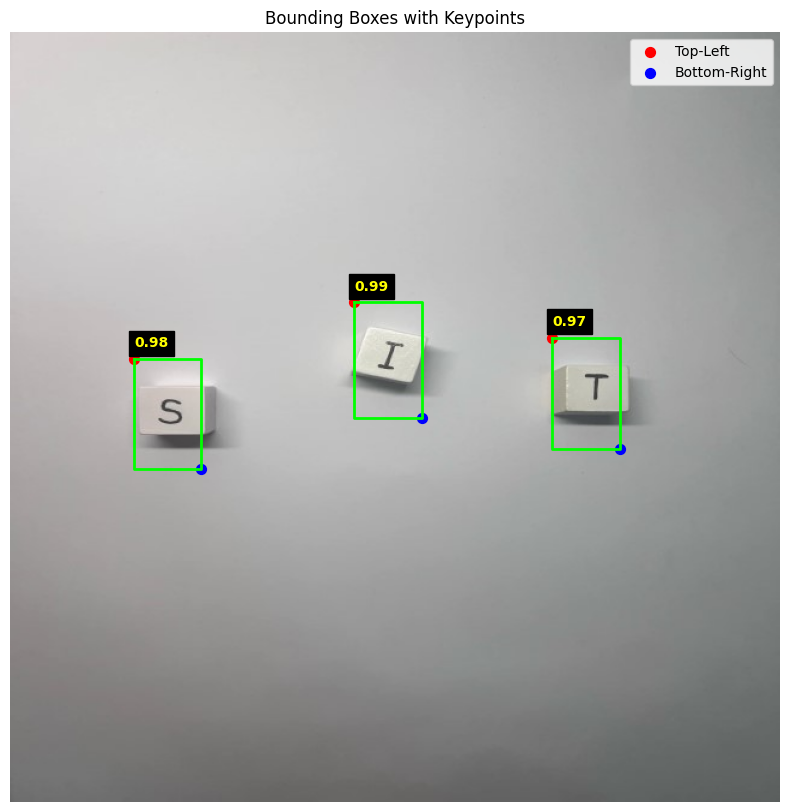

In [ ]:
import os
from torchvision.transforms import ToTensor
from PIL import Image
import matplotlib.pyplot as plt
import torch
from torchvision.models.detection import fasterrcnn_resnet50_fpn

# Visualization function with improved keypoints and confidence filtering
def draw_bounding_boxes_with_keypoints(image, bboxes, keypoints, scores, title="Predictions with Keypoints"):
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    for bbox, (tl, br), score in zip(bboxes, keypoints, scores):
        x1, y1, x2, y2 = bbox
        # Draw bounding box
        plt.plot([x1, x2, x2, x1, x1], [y1, y1, y2, y2, y1], color="lime", linewidth=2)
        # Draw keypoints
        plt.scatter(*tl, color="red", s=50, label="Top-Left" if "Top-Left" not in plt.gca().get_legend_handles_labels()[1] else "")
        plt.scatter(*br, color="blue", s=50, label="Bottom-Right" if "Bottom-Right" not in plt.gca().get_legend_handles_labels()[1] else "")
        # Annotate with confidence score
        plt.text(x1, y1 - 10, f"{score:.2f}", color="yellow", fontsize=10, weight="bold", backgroundcolor="black")
    plt.title(title)
    plt.axis("off")
    plt.legend()
    plt.show()

# Main testing script
if __name__ == "__main__":
    # Paths
    test_image_path = "/content/55555.jpg"  # Path to the test image
    model_weights_path = "/content/cornernet_model.pth"  # Path to the trained model weights

    # Load the Faster R-CNN model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = fasterrcnn_resnet50_fpn(num_classes=2).to(device)
    model.load_state_dict(torch.load(model_weights_path, map_location=device))
    model.eval()

    # Preprocess test image
    image = Image.open(test_image_path).convert("RGB")
    transform = ToTensor()
    image_tensor = transform(image).unsqueeze(0).to(device)

    # Perform inference
    with torch.no_grad():
        predictions = model(image_tensor)[0]  # Get predictions for the first image

    # Extract bounding boxes, scores, and keypoints
    confidence_threshold = 0.5  # Minimum confidence to display
    bounding_boxes = predictions["boxes"].cpu().numpy()
    scores = predictions["scores"].cpu().numpy()
    high_conf_indices = scores > confidence_threshold
    bounding_boxes = bounding_boxes[high_conf_indices]
    scores = scores[high_conf_indices]
    keypoints = [(tuple(bbox[:2]), tuple(bbox[2:])) for bbox in bounding_boxes]  # TL and BR keypoints

    # Debugging
    print("Bounding Boxes:", bounding_boxes)
    print("Keypoints (TL, BR):", keypoints)
    print("Scores:", scores)

    # Visualize bounding boxes and keypoints
    draw_bounding_boxes_with_keypoints(image, bounding_boxes, keypoints, scores, title="Bounding Boxes with Keypoints")


CODE WITH INTERFERENCE TIME

<ipython-input-5-988e3fbf79de>:36: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_weights_path, map_location=device))


Bounding Boxes: [[119.962326  23.36566  143.35623   46.08653 ]]
Keypoints (TL, BR): [((119.962326, 23.36566), (143.35623, 46.08653))]
Scores: [0.6476432]
Inference Time: 0.1701 seconds


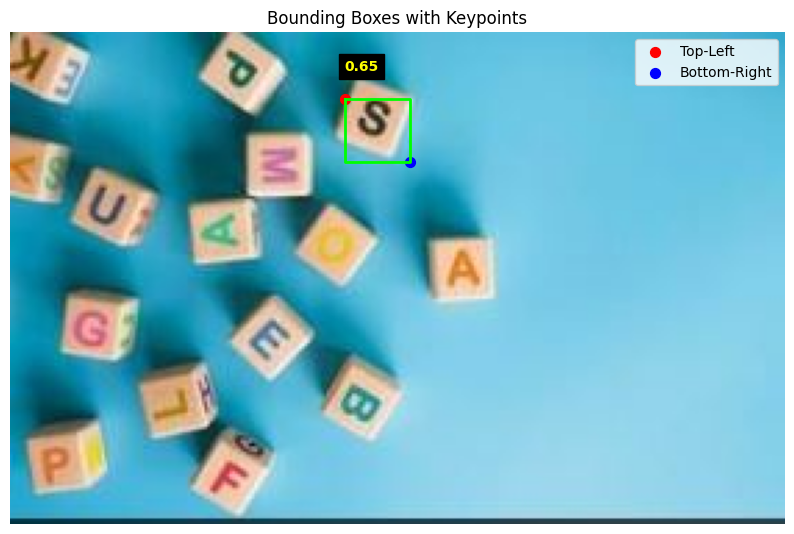

In [ ]:
import os
from torchvision.transforms import ToTensor
from PIL import Image
import matplotlib.pyplot as plt
import torch
from torchvision.models.detection import fasterrcnn_resnet50_fpn
import time

# Visualization function with improved keypoints and confidence filtering
def draw_bounding_boxes_with_keypoints(image, bboxes, keypoints, scores, title="Predictions with Keypoints"):
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    for bbox, (tl, br), score in zip(bboxes, keypoints, scores):
        x1, y1, x2, y2 = bbox
        # Draw bounding box
        plt.plot([x1, x2, x2, x1, x1], [y1, y1, y2, y2, y1], color="lime", linewidth=2)
        # Draw keypoints
        plt.scatter(*tl, color="red", s=50, label="Top-Left" if "Top-Left" not in plt.gca().get_legend_handles_labels()[1] else "")
        plt.scatter(*br, color="blue", s=50, label="Bottom-Right" if "Bottom-Right" not in plt.gca().get_legend_handles_labels()[1] else "")
        # Annotate with confidence score
        plt.text(x1, y1 - 10, f"{score:.2f}", color="yellow", fontsize=10, weight="bold", backgroundcolor="black")
    plt.title(title)
    plt.axis("off")
    plt.legend()
    plt.show()

# Main testing script
if __name__ == "__main__":
    # Paths
    test_image_path = "/content/111.JPG"  # Path to the test image
    model_weights_path = "/content/Bs-16,ep-10cornernet_model.pth"  # Path to the trained model weights

    # Load the Faster R-CNN model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = fasterrcnn_resnet50_fpn(num_classes=2).to(device)
    model.load_state_dict(torch.load(model_weights_path, map_location=device))
    model.eval()

    # Preprocess test image
    image = Image.open(test_image_path).convert("RGB")
    transform = ToTensor()
    image_tensor = transform(image).unsqueeze(0).to(device)

    # Measure inference time
    start_time = time.time()
    with torch.no_grad():
        predictions = model(image_tensor)[0]  # Get predictions for the first image
    end_time = time.time()
    inference_time = end_time - start_time

    # Extract bounding boxes, scores, and keypoints
    confidence_threshold = 0.5  # Minimum confidence to display
    bounding_boxes = predictions["boxes"].cpu().numpy()
    scores = predictions["scores"].cpu().numpy()
    high_conf_indices = scores > confidence_threshold
    bounding_boxes = bounding_boxes[high_conf_indices]
    scores = scores[high_conf_indices]
    keypoints = [(tuple(bbox[:2]), tuple(bbox[2:])) for bbox in bounding_boxes]  # TL and BR keypoints

    # Debugging
    print("Bounding Boxes:", bounding_boxes)
    print("Keypoints (TL, BR):", keypoints)
    print("Scores:", scores)
    print(f"Inference Time: {inference_time:.4f} seconds")

    # Visualize bounding boxes and keypoints
    draw_bounding_boxes_with_keypoints(image, bounding_boxes, keypoints, scores, title="Bounding Boxes with Keypoints")
